###1) CIFAR-10

In [ ]:
!pip install tensorflow-datasets

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as cats_vs_dogs

In [ ]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = cats_vs_dogs.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZZOBSH/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZZOBSH/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})


In [ ]:
# 데이터의 개수도 확인해 봅시다.
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


###2) Input Normalization

In [ ]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 정규화 코드를 작성해봅시다.

def normalize_and_resize_img(image, label):
    # 이미지 데이터를 float32 데이터 타입으로 변경합니다.
    image = tf.cast(image, tf.float32)
    # 이미지 데이터를 [0, 255] 범위에서 [0, 1] 범위로 정규화합니다.
    image /= 255.0
    return image, label

# 함수를 테스트하기 위해 임의의 이미지 데이터와 레이블을 생성하고 함수를 호출합니다.
import tensorflow as tf
import numpy as np

# 28x28 크기의 이미지를 생성하고 레이블을 1로 설정합니다.
test_image = np.random.randint(0, 256, size=(28, 28), dtype=np.uint8)
test_label = 1

# 함수 호출 및 결과 확인
normalize_and_resize_img(test_image, test_label)


(<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
 array([[0.22745098, 0.7647059 , 0.12941177, 0.88235295, 0.96862745,
         0.32941177, 0.4509804 , 0.87058824, 0.6039216 , 0.8862745 ,
         0.49411765, 0.21568628, 0.85490197, 0.5568628 , 0.7647059 ,
         0.19215687, 0.6901961 , 0.14117648, 0.5411765 , 0.4862745 ,
         0.9254902 , 0.9607843 , 0.36078432, 0.7294118 , 0.28235295,
         0.04313726, 0.9098039 , 0.        ],
        [0.45882353, 0.7529412 , 0.02745098, 0.6       , 0.9529412 ,
         0.7137255 , 0.61960787, 0.8745098 , 0.8352941 , 0.20784314,
         0.1254902 , 0.49411765, 0.5921569 , 0.5411765 , 0.99607843,
         0.34509805, 0.85490197, 0.7058824 , 0.8627451 , 0.8       ,
         0.5686275 , 0.9764706 , 0.9137255 , 0.00392157, 0.54901963,
         0.2       , 0.9137255 , 0.3764706 ],
        [0.9607843 , 0.85882354, 0.03921569, 0.23921569, 0.11372549,
         0.4117647 , 0.06666667, 0.99215686, 0.58431375, 0.5686275 ,
         0.63529414, 0.882352

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
ds_info.features["label"].num_classes

10

In [ ]:
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

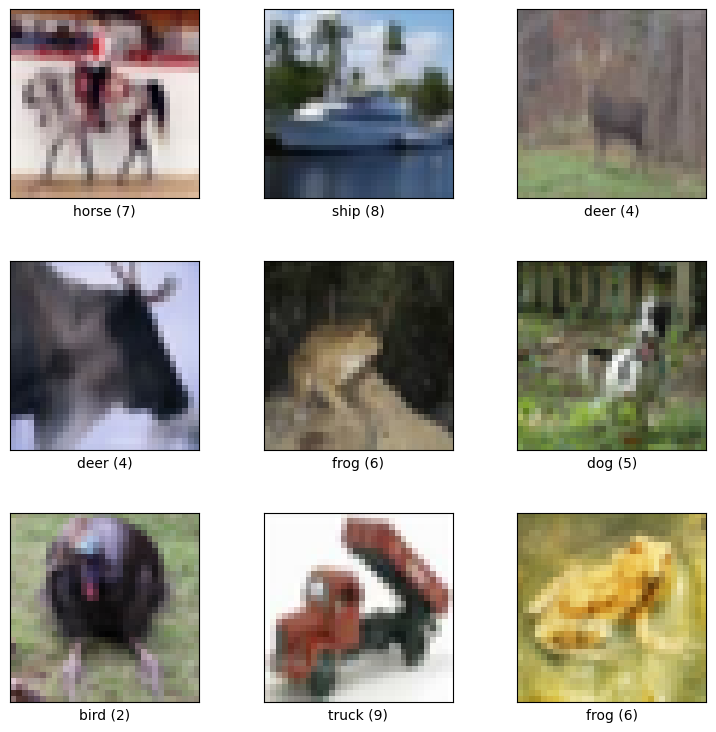

In [ ]:
fig = cats_vs_dogs.show_examples(ds_train, ds_info)

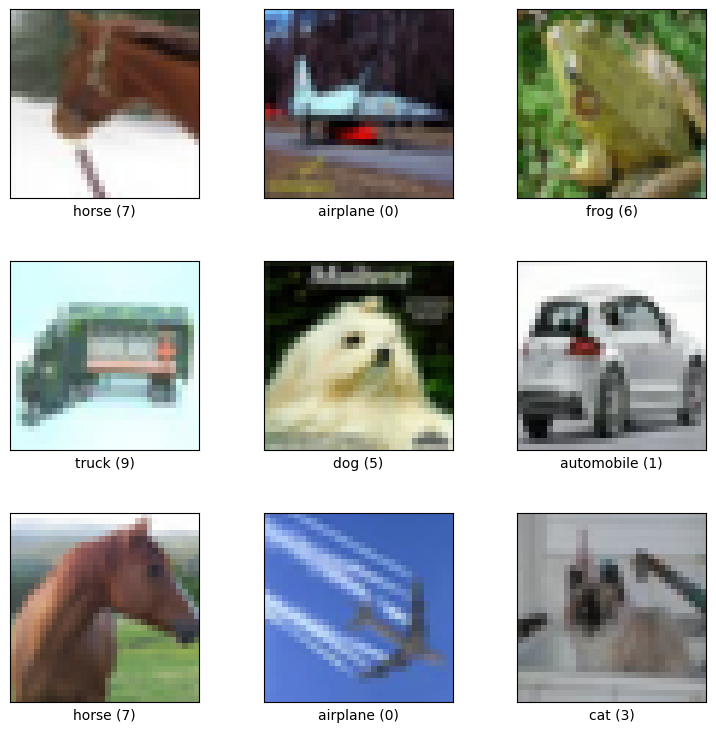

In [ ]:
fig = cats_vs_dogs.show_examples(ds_test, ds_info)

###VGG기본블록만들기

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1,
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [ ]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성

In [ ]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
Total params: 75648 (295.50 KB)
Trainable params: 75648 (295.50 KB)
Non-trainable params: 0 (0.00 Byte)
_______________________

##(3) VGG Complete Model<BR>
####1) VGG-16

In [ ]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):

    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.

    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i
        )

    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer,
        outputs=output
    )
    return model

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

####2) VGG-19

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block0_pooling (MaxPooling  (None, 16, 16, 64)        0         
 2D)                                                             
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

In [ ]:
## Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.

from tensorflow.keras import models, layers

def build_vgg(num_cnn_list, channel_list):
    model = models.Sequential()
    # 입력층
    model.add(layers.InputLayer(input_shape=(224, 224, 3)))

    # CNN 블록
    for num_cnn, channels in zip(num_cnn_list, channel_list):
        for _ in range(num_cnn):
            model.add(layers.Conv2D(channels, (3, 3), padding='same', activation='relu'))
        model.add(layers.MaxPooling2D((2, 2), strides=2))

    # 분류를 위한 완전 연결 레이어
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dense(1000, activation='softmax'))  # 1000개의 클래스를 가정

    return model

# VGG-13 모델 생성
vgg_13 = build_vgg(
    num_cnn_list=[2, 2, 2, 2],  # 각 블록당 2개의 CNN 레이어
    channel_list=[64, 128, 256, 512]  # 채널 수 설정
)

# 모델 구조 요약
vgg_13.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

## (4) VGG-16 vs VGG-19

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = cats_vs_dogs.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 47s 137ms/step - loss: 2.1746 - accuracy: 0.1933 - val_loss: 2.0774 - val_accuracy: 0.2633
Epoch 2/15
195/195 [==============================] - 25s 126ms/step - loss: 1.9895 - accuracy: 0.2821 - val_loss: 1.9156 - val_accuracy: 0.2928
Epoch 3/15
195/195 [==============================] - 23s 116ms/step - loss: 1.8620 - accuracy: 0.3328 - val_loss: 1.7721 - val_accuracy: 0.3614
Epoch 4/15
195/195 [==============================] - 25s 127ms/step - loss: 1.7460 - accuracy: 0.3757 - val_loss: 1.6968 - val_accuracy: 0.3708
Epoch 5/15
195/195 [==============================] - 22s 114ms/step - loss: 1.6608 - accuracy: 0.4020 - val_loss: 1.6279 - val_accuracy: 0.4149
Epoch 6/15
195/195 [==============================] - 25s 126ms/step - loss: 1.5944 - accuracy: 0.4278 - val_loss: 1.5262 - val_accuracy: 0.4403
Epoch 7/15
195/195 [==============================] - 25s 126ms/step - loss: 1.5524 - accuracy: 0.4401 - val_loss: 1.5019 - val_ac

In [26]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 33s 138ms/step - loss: 2.2308 - accuracy: 0.1623 - val_loss: 2.1201 - val_accuracy: 0.2232
Epoch 2/15
195/195 [==============================] - 29s 148ms/step - loss: 2.0451 - accuracy: 0.2539 - val_loss: 2.0076 - val_accuracy: 0.2790
Epoch 3/15
195/195 [==============================] - 28s 146ms/step - loss: 1.9051 - accuracy: 0.3091 - val_loss: 1.8270 - val_accuracy: 0.3474
Epoch 4/15
195/195 [==============================] - 26s 136ms/step - loss: 1.7697 - accuracy: 0.3611 - val_loss: 1.7124 - val_accuracy: 0.3845
Epoch 5/15
195/195 [==============================] - 27s 137ms/step - loss: 1.6788 - accuracy: 0.3918 - val_loss: 1.6144 - val_accuracy: 0.4299
Epoch 6/15
195/195 [==============================] - 28s 146ms/step - loss: 1.6097 - accuracy: 0.4157 - val_loss: 1.5689 - val_accuracy: 0.4306
Epoch 7/15
195/195 [==============================] - 29s 146ms/step - loss: 1.5505 - accuracy: 0.4392 - val_loss: 1.5091 - val_ac

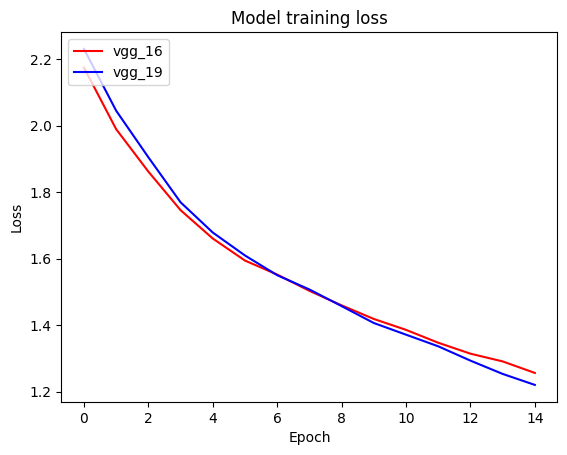

In [27]:
#훈련 손실(training loss)이 어떻게 다르게 진행되는지 비교

import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

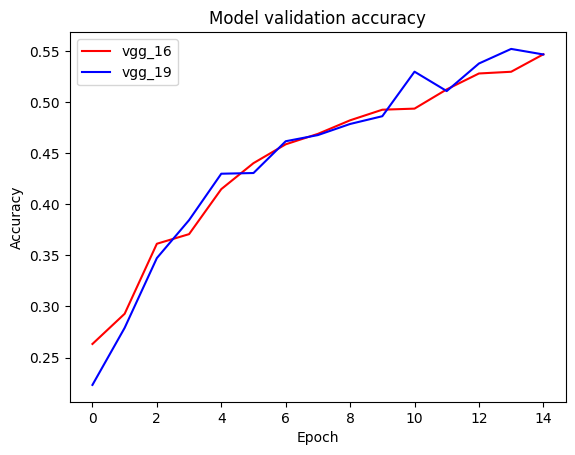

In [28]:
#검증 정확도(validation accuracy)

plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

###ResNet Ablation Study

####0) 라이브러리 버전 확인하기

In [29]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.15.0
1.23.5


####2) ResNet-34, ResNet-50 Complete Mode

In [32]:
import tensorflow_datasets as tfds
import tensorflow as tf

# cats_vs_dogs 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

# 데이터 전처리 함수
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# 데이터셋 전처리
ds_train = ds_train.map(preprocess).batch(32).prefetch(1)
ds_test = ds_test.map(preprocess).batch(32).prefetch(1)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteLU7OHM/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [33]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.models import Model

def conv_batchnorm_relu(x, filters, kernel_size, strides=1):
    x = Conv2D(filters, kernel_size, strides=strides, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

def residual_block(x, filters, kernel_size=3, reduce=False):
    y = conv_batchnorm_relu(x, filters, kernel_size, strides=2 if reduce else 1)
    y = conv_batchnorm_relu(y, filters, kernel_size)

    if reduce:
        x = Conv2D(filters, 1, strides=2, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)

    return Add()([x, y])

def bottleneck_block(x, filters, reduce=False):
    y = conv_batchnorm_relu(x, filters, 1)
    y = conv_batchnorm_relu(y, filters, 3, strides=2 if reduce else 1)
    y = conv_batchnorm_relu(y, filters * 4, 1)

    if reduce or x.shape[-1] != filters * 4:
        x = Conv2D(filters * 4, 1, strides=2 if reduce else 1, padding="same", use_bias=False)(x)
        x = BatchNormalization()(x)

    return Add()([x, y])

def build_resnet(input_shape, is_50):
    input_layer = Input(shape=input_shape)

    # 초기 레이어
    x = conv_batchnorm_relu(input_layer, 64, 7, strides=2)
    x = MaxPooling2D(3, strides=2, padding="same")(x)

    # 중간 레이어
    num_blocks_list = [3, 4, 6, 3] if is_50 else [3, 4, 6, 3]
    block_function = bottleneck_block if is_50 else residual_block

    for i, num_blocks in enumerate(num_blocks_list):
        for j in range(num_blocks):
            x = block_function(x, 64 * (2**i), reduce=j==0 and i!=0)

    # 최종 레이어
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation="softmax")(x)

    model = Model(inputs=input_layer, outputs=x)
    return model

# ResNet-34 모델 생성
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

# ResNet-50 모델 생성
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_98 (Conv2D)          (None, 16, 16, 64)           9408      ['input_8[0][0]']             
                                                                                                  
 batch_normalization_90 (Ba  (None, 16, 16, 64)           256       ['conv2d_98[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 re_lu_83 (ReLU)             (None, 16, 16, 64)           0         ['batch_normalization_90

In [ ]:
# 모델 구성은 앞서 제공된 build_resnet 함수 사용

# ResNet-50 모델 생성 및 컴파일
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ResNet-50 모델 학습
history_50 = resnet_50.fit(ds_train, validation_data=ds_test, epochs=5)

# ResNet-34 모델 생성 및 컴파일
resnet_34 = build_resnet(input_shape=(224, 224, 3), is_50=False)
resnet_34.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# ResNet-34 모델 학습
history_34 = resnet_34.fit(ds_train, validation_data=ds_test, epochs=5)


Epoch 1/5
582/582 [==============================] - 242s 360ms/step - loss: 0.7785 - accuracy: 0.6047 - val_loss: 0.9431 - val_accuracy: 0.5127
Epoch 2/5
582/582 [==============================] - 202s 347ms/step - loss: 0.6304 - accuracy: 0.6695 - val_loss: 2.3727 - val_accuracy: 0.4742
Epoch 3/5
582/582 [==============================] - 202s 347ms/step - loss: 0.5660 - accuracy: 0.7171 - val_loss: 0.9401 - val_accuracy: 0.5114
Epoch 4/5
582/582 [==============================] - 202s 347ms/step - loss: 0.5466 - accuracy: 0.7333 - val_loss: 0.5873 - val_accuracy: 0.7221
Epoch 5/5
582/582 [==============================] - 209s 358ms/step - loss: 0.5011 - accuracy: 0.7622 - val_loss: 0.7138 - val_accuracy: 0.6681
Epoch 1/5
582/582 [==============================] - 128s 190ms/step - loss: 0.7261 - accuracy: 0.5923 - val_loss: 0.7670 - val_accuracy: 0.5110
Epoch 2/5
582/582 [==============================] - 108s 185ms/step - loss: 0.6334 - accuracy: 0.6505 - val_loss: 0.7081 - val_ac

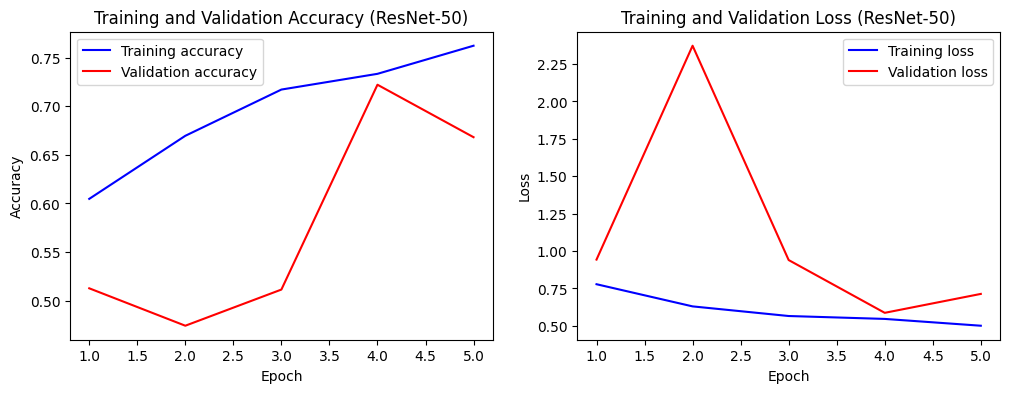

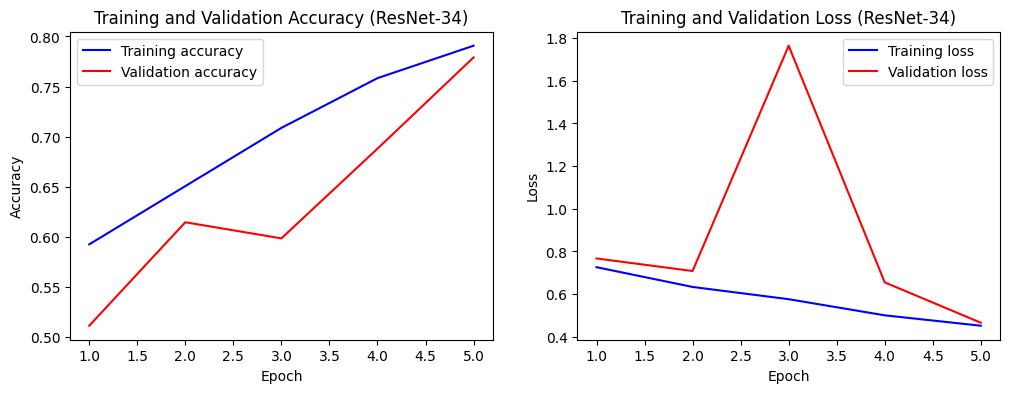

In [35]:
#시각화

import matplotlib.pyplot as plt

def plot_training_history(history, title=''):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation loss')
    plt.title('Training and Validation Loss ' + title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# ResNet-50의 학습 결과 시각화
plot_training_history(history_50, title='(ResNet-50)')

# ResNet-34의 학습 결과 시각화
plot_training_history(history_34, title='(ResNet-34)')
